In [ ]:
!pip install tensorflow
!pip install tensorflow

In [ ]:
!pip install tensorflow

In [138]:
import pandas as pd
import sys
import tensorflow.keras
import scipy as sp
import tensorflow as tf
import platform
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from transformers import TFBertModel # This will load the hugging face bert transformer and set it's parameters to tensorflow
# import tensorflow_hub as hub # to load the bert directly from tensorflow hub, already compatible with tensorflow environment.
import re
import os

## Load Datasets

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [115]:
import os
os.chdir('/content/drive/My Drive/ML_Advance/lab2_transfer_learning/data/')

df = pd.read_csv('imdb.csv')

In [116]:
print(df.groupby('sentiment').count())
print(df.head())

           review
sentiment        
negative    25000
positive    25000
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [117]:
tf.config.list_logical_devices('TPU')

[LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'),
 LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'),
 LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'),
 LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'),
 LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'),
 LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'),
 LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'),
 LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]

In [118]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [119]:
print("Num TPUs Available: ", len(tf.config.list_logical_devices('TPU')))

Num TPUs Available:  8


### Preprocess the dataset

### Remove Unwanted characters, and try to use only the first 20000 rows of the data to speed up our fine-tunning.
- remove punctuation marks
- remove characters which are not letters or digits
- remove successive whitespaces
- convert the text to lower case
- strip whitespaces from the beginning and the end of the reviews

In [120]:
df = df.head(20000)
df.sentiment = [0 if s == 'negative' else 1 for s in df.sentiment]
def process(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    x = re.sub('\s+', ' ', x)
    return x.lower().strip()

df['review'] = df['review'].apply(lambda x: process(x))

<ipython-input-120-6c7883b5864b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sentiment = [0 if s == 'negative' else 1 for s in df.sentiment]


#### Plot the data distribution over the labels
- Determine how balance the dataset is.

In [121]:
print(df.sentiment.head())
print(df.shape)


0    1
1    1
2    1
3    0
4    1
Name: sentiment, dtype: int64
(20000, 2)


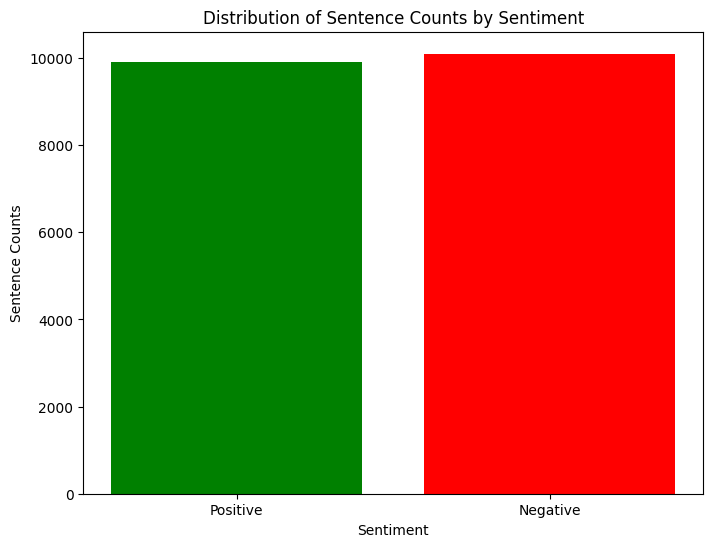

In [122]:
# Calculate the number of sentences for each sentiment category
positive_counts = len(df[df.sentiment == 1])
negative_counts = len(df[df.sentiment == 0])

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(['Positive', 'Negative'], [positive_counts, negative_counts], color=['green', 'red'])
plt.title('Distribution of Sentence Counts by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Sentence Counts')
plt.show()

#### Prepare data for Bert, padding them (masking them appropriately)
Let’s first see how the BERT tokenizer converts sentences into token ids. token ids : it is an integer that represents a particular token.

**attention mask** : it is a sequence of ones and zeroes to tell the model which token comes from input sentence (segment id =1) and which are just padding token(segment id =0).

**padding** : when we train BERT model we make sure that every input to the model should have same size that means same length of inputs so that the model can perform back propagation efficiently but all our input which are review text can not be in same size, some can be small review and some can be large. Padding is the technique where we make our entire review in the same size but first we have to decide a fixed length or max_length.

##### Split our dataset into 80/20
- Since these dataset is balanced and have enough dataset for splitting, it make sense that we can use 80/20

In [123]:
train, test = train_test_split(df, test_size=0.2)

train_sentences = train.review
train_labels = train.sentiment
test_sentences = test.review
test_labels = test.sentiment


print(train_sentences.shape, test_sentences.shape)
print(train_labels.shape, test_labels.shape)

(16000,) (4000,)
(16000,) (4000,)


#### Masking and Padding dataset
Hugging face library provides another function called tokenizer.encode_plus() which we will use to perform almost entire preprocessing steps in one go. It

converts reviews into tokens
adds [CLS] token at the beginning of input
performs padding if sequence length is less than max_len
performs truncation if sequence length is greater than max_len
adds [SEP] token at the end of sequence.

In [124]:
with strategy.scope():
    # Load the BERT tokenizer
    print('Loading BERT tokenizer...')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
MAX_LEN = 512
EPOCCH = 30
BATCH_SIZE = 32

In [105]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
# def generate_data(data,labels):
#   input_ids = []
#   attention_masks = []

#   for sent in data:
#       # `encode_plus` will:
#       #   (1) Tokenize the sentence.
#       #   (2) Prepend the `[CLS]` token to the start.
#       #   (3) Append the `[SEP]` token to the end.
#       #   (4) Map tokens to their IDs.
#       #   (5) Pad or truncate the sentence to `max_length`
#       #   (6) Create attention masks for [PAD] tokens.
#       encoded_dict = tokenizer.encode_plus(
#                           sent,                      # Sentence to encode.
#                           add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                           max_length = 64,           # Pad & truncate all sentences.
#                           pad_to_max_length = True,
#                           return_attention_mask = True,   # Construct attn. masks.
#                           truncation = True,
#                           return_tensors = 'tf',     # Return pytorch tensors.
#                     )

#       # Add the encoded sentence to the list.
#       input_ids.append(encoded_dict['input_ids'])

#       # And its attention mask (simply differentiates padding from non-padding).
#       attention_masks.append(encoded_dict['attention_mask'])

#   # Convert the lists into tf.
#   # this can be a duplicate since we're already returning tensorflow tensors.
#   # input_ids = tf.convert_to_tensor(input_ids)
#   # attention_masks = tf.convert_to_tensor(attention_masks)
#   labels = tf.convert_to_tensor(labels)

#   return input_ids, attention_masks, labels

In [125]:
def generate_data(data, labels):
    """Generates tf.data.Dataset from input data."""
    print("tokenizing...")
    X_train = tokenizer(
          text=data.tolist(),
          add_special_tokens=True,
          max_length=MAX_LEN,
          pad_to_max_length=True
          truncation=True,
          padding=True,
          return_tensors='tf',
          return_token_type_ids=False,
          return_attention_mask=True,
          verbose=True
      )

    labels = tf.convert_to_tensor(labels)

    return X_train, labels

In [126]:
%%time

with strategy.scope():
  tf.debugging.set_log_device_placement(True)

  train_ds, train_labels = generate_data(train_sentences, train_labels)
  test_ds, test_labels = generate_data(test_sentences, test_labels)

  print(train_ds)
  print(train_labels)
  print(test_ds)
  print(test_labels)


tokenizing...
tokenizing...
{'input_ids': <tf.Tensor: shape=(16000, 70), dtype=int32, numpy=
array([[  101,  1045,  3685, ...,  2052,  3891,   102],
       [  101,  1045,  2018, ..., 12689, 13764,   102],
       [  101,  3348,  2080, ..., 22917,  2839,   102],
       ...,
       [  101,  1996,  2060, ...,  7935,  2003,   102],
       [  101,  1045,  5993, ...,  1997,  2184,   102],
       [  101,  5261,  4670, ...,  2023,  9200,   102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(16000, 70), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}
tf.Tensor([0 0 0 ... 0 0 0], shape=(16000,), dtype=int64)
{'input_ids': <tf.Tensor: shape=(4000, 70), dtype=int32, numpy=
array([[  101,  2066,  2116, ...,  4458,  1998,   102],
       [  101,  2023,  3185, ...,  1055,  9951,   102],
       [  101,  1037

### Load the Model and set it up for Feature space transfers

In [127]:
# load the bert directly from the hugging face and it'll be initialize to tensorflow for compatibility
with strategy.scope():
  bert_model = TFBertModel.from_pretrained('bert-base-uncased', trainable=False)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [128]:
%%time

def save_bottleneck_features(ds, labels, filename_addendum):
    """Saves bottleneck features extracted from a frozen BERT model."""
    bottleneck_features = []
    labels_train = []
    i = 1
    with strategy.scope():
      print(f'Extracting bottleneck features for {filename_addendum}')
      bottleneck_features.extend(bert_model(ds)['pooler_output'].numpy())

      print(f'Extending labels into numpy feature space for {filename_addendum}')
      # Get the labels as well
      labels_train.extend(labels)

      bottleneck_features = np.array(bottleneck_features)
      labels_train = np.array(labels_train)

      print(f'Saving bottleneck features for {filename_addendum}')
      np.save(f'./bottleneck_features_{filename_addendum}.npy', bottleneck_features)
      np.save(f'./bottleneck_labels_{filename_addendum}.npy', labels_train)

CPU times: user 18 µs, sys: 4 µs, total: 22 µs
Wall time: 42.7 µs


In [129]:
# Wrap the feature extraction function within the TPU strategy scope
with strategy.scope():
    # Save training features
    print('Saving bottleneck features (train)...')
    save_bottleneck_features(train_ds, train_labels, 'train')

    # Save validation features
    print('Saving bottleneck features (test)...')
    save_bottleneck_features(test_ds, test_labels, 'test')

Saving bottleneck features (train)...
Saving bottleneck features (test)...


### Train a classifier layer with extracted features
- Now we can train our classifier with the extracted features
- The classifier is simply a fully connected layer with 256 hidden units

In [132]:
# Build model
with strategy.scope():
  print('Building text classification model...')
  top_model = tf.keras.Sequential(name='imdb_classifier')

  # Flatten the embedded sequence into a dense vector
  top_model.add(layers.Flatten(name='flatten_layer'))

  # Fully connected layers with activation functions and dropout
  top_model.add(layers.Dense(256, activation='relu', name='dense_1'))
  top_model.add(layers.Dropout(0.5))
  top_model.add(layers.Dense(128, activation='relu', name='dense_2'))
  top_model.add(layers.Dropout(0.2))

  # Output layer with sigmoid for binary classification
  top_model.add(layers.Dense(1, activation='sigmoid', name='output_layer'))

  # Compile the model with appropriate loss and metrics
  top_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

Building text classification model...


#### Train the top model

##### Load the foundational model saved feature space

In [135]:
with strategy.scope():
  # Load bottleneck features that have already been extracted by base model
  train_data = np.load('./bottleneck_features_train.npy')
  # the first half of labels are sharks, and second half are dolphins
  train_labels = np.load('./bottleneck_labels_train.npy')
  print('Training Data Shape: ',train_data.shape, 'Training Label Shape: ',train_labels.shape)

  validation_data = np.load('./bottleneck_features_test.npy')
  # the first half of labels are sharks, and second half are dolphins
  validation_labels = np.load('./bottleneck_labels_test.npy')
  print('Val Data Shape: ',validation_data.shape, 'Val Label Shape: ', validation_labels.shape)



Training Data Shape:  (16000, 768) Training Label Shape:  (16000,)
Val Data Shape:  (4000, 768) Val Label Shape:  (4000,)


In [147]:
%%time

# Define the directory where you want to save the checkpoint file
checkpoint_dir = '/content/drive/My Drive/ML_Advance/lab2_transfer_learning/checkpoints/'
# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the directory where you want to save the top model weights and model itself
top_model_dir = '/content/drive/My Drive/ML_Advance/lab2_transfer_learning/models/top_model/'
# Create the directory if it doesn't exist
os.makedirs(top_model_dir, exist_ok=True)

# Train model
with strategy.scope():
    # setup params and where to save features
    epochs = 30
    batch_size = 64

    print('Training top model, saving the checkpoint...')
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'checkpoint_{epoch:02d}.h5'),
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    print('Training transfer model from bottleneck...')
    history = top_model.fit(train_data, train_labels,
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[model_checkpoint_callback],
                            validation_data=(validation_data, validation_labels),
                            verbose=1)

    print('Training complete.')

     # Save top model weights
    print('Saving top model weights...')
    top_model_weights_path = os.path.join(top_model_dir, 'top_model_weights.h5')
    top_model.save_weights(top_model_weights_path)

    # Save the entire top model
    print('Saving the top model...')
    top_model.save(os.path.join(top_model_dir, 'top_model.h5'))
    print('Done!')

Training top model, saving the checkpoint...
Training transfer model from bottleneck...
250/250 [==============================] - 4s 16ms/step - loss: 0.5414 - accuracy: 0.6858 - val_loss: 0.5433 - val_accuracy: 0.7548
Training complete.
Saving top model weights...
Saving the top model...
Done!
CPU times: user 2.58 s, sys: 384 ms, total: 2.97 s
Wall time: 5.5 s


#### Plot the result

In [149]:
def plot_training_validation_acc(history, smooth=False, smooth_factor=0.8):
    def smooth_curve(points, factor=0.8):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    if smooth:
        acc = smooth_curve(acc)
        val_acc = smooth_curve(val_acc)
        loss = smooth_curve(loss)
        val_loss = smooth_curve(val_loss)

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


In [ ]:
plot_training_validation_acc(history)

#### Fine-Tune the bert
- unfreeze 1 layer of bert and try to combine all the models together and train them, comparing it's performance with the old one.

In [ ]:
%%time

# # Define function to unfreeze the last layer
# def unfreeze_last_layer(model):
#   """Unfreezes the last layer of a BERT model (classification head)."""
#   set_trainable = False
#   for layer in model.bert.encoder.layer[-1:]:
#     for param in layer.parameters:
#       param.requires_grad = True

 # make it work correctly with a TensorFlow/Keras BERT model loaded from Hugging Face Transformers.
def unfreeze_last_layer(model):
    """Unfreezes the last layer of a BERT model (classification head)."""
    model.trainable = False  # Set the entire model as non-trainable
    for layer in model.layers:
        if 'bert' in layer.name:  # Check if the layer belongs to the BERT model
            for sub_layer in layer.layers[-1:]:  # Unfreeze the last layer of the BERT model
                sub_layer.trainable = True

In [ ]:
%%time

#
# Fine tune top bert 1st layer (classifier layer)
#

print('Building combined model...')

# add the model on top of the top model base
model = tf.keras.Model(inputs=bert_model.input,
              outputs=top_model(bert_model.output))



# now let's fine tune one layer within Bert
# Freeze all blocks up to first layer (the block we are fine tuning)
unfreeze_last_layer(bert_model)

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

In [ ]:
checkpoint_filepath = 'models/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

print('Fine tuning combined model...')
history = model.fit(train_ds,
              epochs=epochs,
              batch_size=16,
              callbacks=[model_checkpoint_callback],
              validation_data=test_ds,
              verbose=1)

#### Plot the result of the fine tuned model.

In [ ]:
plot_training_validation_acc(history, smooth=True)

In [ ]:
test_loss, test_acc = model.evaluate(val_ds)
print('test acc:', test_acc)